## Index

- [1. Configurations](#sec1)
  - [1.1 Dataset Upload](#sec11)
  - [1.2 MLFlow](#sec12)
- [2. PCA](#sec2)
  - [2.1 Split and Scaling](#sec21)
  - [2.2 Explore PCA to Geometric dataset](#sec22)
  - [2.3 PCA full variables](#sec23)
  - [2.4 Select PCA to Geometric dataset](#sec24)
- [3. Modeling phase K-Neighbors](#sec3)
  - [3.1 K-Neighbors without PCA](#sec31)
  - [3.2 K-Neighbors with PCA](#sec32)
- [4. Modeling phase Neural Network](#sec4)
  - [4.1 Neural Network without PCA](#sec41)
  - [4.2 Neural Network with PCA](#sec42)
- [5. Modeling phase Cluster](#sec5)
  - [5.1 PCA with 2 principal components and clustering](#sec51)
  - [5.2 PCA with 3 principal components and clustering](#sec52)
  - [5.3 PCA with 17 principal components and clustering](#sec53)
  - [5.4 Without PCA and clustering](#sec54)
- [6. Modeling phase BNN](#sec6)
- [7. Comparation](#sec7)
- [8. Prediction](#sec8)
- [9. Conclusion](#sec9)


In [3]:

# Bibliotecas a usar
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import warnings
import tensorflow as tf
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import mode
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    )

import bnlearn as bn


2026-01-06 14:55:24.521059: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-06 14:55:24.567605: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-06 14:55:26.566792: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## <span id="sec1"></span> **1. Configurations**

### <span id="sec11"></span> **1.1 Dataset Upload**

In [4]:
df_geometric = pd.read_csv("../_attachments/datasets/data-set-geometric-labels.csv", sep=',')
print("Dataset geometric loaded successfully")
df_geometric.head()

Dataset geometric loaded successfully


AGE  AQ10_TOTAL_SCORE  FINE_DETAILS_AQ_1  GLOBAL_FOCUS_AQ_2  \
0  26.0               6.0                1.0                1.0   
1  24.0               5.0                1.0                1.0   
2  27.0               8.0                1.0                1.0   
3  35.0               6.0                1.0                1.0   
4  40.0               2.0                1.0                0.0   

   FOLLOW_CONVERSATIONS_AQ_3  TASK_SWITCHING_AQ_4  UNDERSTAND_INTENTIONS_AQ_5  \
0                        1.0                  1.0                         0.0   
1                        0.0                  1.0                         0.0   
2                        0.0                  1.0                         1.0   
3                        0.0                  1.0                         0.0   
4                        0.0                  0.0                         0.0   

   NOTICE_INTEREST_AQ_6  SOCIAL_IMAGINATION_AQ_7  INTENSE_INTERESTS_AQ_8  ...  \
0                   0.0                      1.0                     1.0  ...   
1                   0.0                      0.0                     1.0  ...   
2                   0.0                      1.0                     1.0  ...   
3                   0.0                      1.0                     1.0  ...   
4                   0.0                      0.0                     1.0  ...   

   ETHNICITY_Hispanic  ETHNICITY_Latino  ETHNICITY_Middle Eastern   \
0                 0.0               0.0                        0.0   
1                 0.0               1.0                        0.0   
2                 0.0               1.0                        0.0   
3                 0.0               0.0                        0.0   
4                 0.0               0.0                        0.0   

   ETHNICITY_Others  ETHNICITY_Pasifika  ETHNICITY_South Asian  \
0               0.0                 0.0                    0.0   
1               0.0                 0.0                    0.0   
2               0.0                 0.0                    0.0   
3               0.0                 0.0                    0.0   
4               0.0                 0.0                    0.0   

   ETHNICITY_Turkish  ETHNICITY_White-European  ETHNICITY_others  ASD_TARGET  
0                0.0                       1.0               0.0           0  
1                0.0                       0.0               0.0           0  
2                0.0                       0.0               0.0           1  
3                0.0                       1.0               0.0           0  
4                0.0                       0.0               0.0           0  

[5 rows x 30 columns]

In [5]:
df_bayesian = pd.read_csv("../_attachments/datasets/data-set-bayesian-labels.csv", sep=',')
print("Dataset geometric loaded successfully")
df_bayesian.head()

Dataset geometric loaded successfully


FINE_DETAILS_AQ_1  GLOBAL_FOCUS_AQ_2  FOLLOW_CONVERSATIONS_AQ_3  \
0                1.0                1.0                        1.0   
1                1.0                1.0                        0.0   
2                1.0                1.0                        0.0   
3                1.0                1.0                        0.0   
4                1.0                0.0                        0.0   

   TASK_SWITCHING_AQ_4  UNDERSTAND_INTENTIONS_AQ_5  NOTICE_INTEREST_AQ_6  \
0                  1.0                         0.0                   0.0   
1                  1.0                         0.0                   0.0   
2                  1.0                         1.0                   0.0   
3                  1.0                         0.0                   0.0   
4                  0.0                         0.0                   0.0   

   SOCIAL_IMAGINATION_AQ_7  INTENSE_INTERESTS_AQ_8  \
0                      1.0                     1.0   
1                      0.0                     1.0   
2                      1.0                     1.0   
3                      1.0                     1.0   
4                      0.0                     1.0   

   READ_FACIAL_EXPRESSIONS_AQ_9  SOCIAL_FRIENDSHIP_AQ_10  JAUNDICE  \
0                           0.0                      0.0       0.0   
1                           0.0                      1.0       0.0   
2                           1.0                      1.0       1.0   
3                           0.0                      1.0       0.0   
4                           0.0                      0.0       0.0   

   AUTISM_FAMILY_HISTORY  USED_APP_BEFORE  GENDER  ETHNICITY  AGE  \
0                    0.0              0.0     0.0       10.0  1.0   
1                    1.0              0.0     1.0        4.0  1.0   
2                    1.0              0.0     1.0        4.0  2.0   
3                    1.0              0.0     0.0       10.0  3.0   
4                    0.0              0.0     0.0        0.0  3.0   

   AQ10_TOTAL_SCORE  ASD_TARGET  
0               2.0           0  
1               2.0           0  
2               3.0           1  
3               2.0           0  
4               0.0           0

### <span id="sec12"></span> **1.2 Ml Flow**

In [6]:
warnings.filterwarnings('ignore')
mlflow.set_tracking_uri("file:../mlruns")

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

def compute_metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1_score": f1_score(y_true, y_pred)
    }

def plot_confusion_matrix(y_true, y_pred, name):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    fig.tight_layout()
    
    save_path = f"{name}_cm.png"
    fig.savefig(save_path)
    mlflow.log_artifact(save_path)
    os.remove(save_path)
    plt.close(fig)
    #return fig

## <span id="sec2"></span> **2. PCA**

### <span id="sec21"></span> **2.1 Split and Scaling**


In [7]:
X_geometric = df_geometric.drop(columns=["ASD_TARGET"])
y_geometric = df_geometric["ASD_TARGET"]

X_geometric_train, X_geometric_test, y_geometric_train, y_geometric_test = train_test_split(
    X_geometric,
    y_geometric,
    test_size=0.2,
    random_state=42,
    stratify=y_geometric
)

scaler_geometric = StandardScaler()

X_geometric_train_scaled = scaler_geometric.fit_transform(
    X_geometric_train
)

X_geometric_test_scaled = scaler_geometric.transform(
    X_geometric_test
)

### <span id="sec22"></span> **2.2 Explore PCA to Geometric dataset**
An exploratory PCA was performed on the geometric dataset to analyze the distribution of explained variance across principal components and assess feature redundancy.

In [8]:
pca_2 = PCA(n_components=2, random_state=42)
X_pca_2 = pca_2.fit_transform(X_geometric_train_scaled)

df_pca_2 = pd.DataFrame(
    X_pca_2,
    columns=["PC1", "PC2"]
)

df_pca_2["ASD_TARGET"] = y_geometric_train.values

fig_2d = px.scatter(
    df_pca_2,
    x="PC1",
    y="PC2",
    color="ASD_TARGET",
    #title="PCA 2D – Geometric Dataset",
    opacity=0.7,
    height=1144
)

fig_2d.show()


In [9]:
pca_3 = PCA(n_components=3, random_state=42)
X_pca_3 = pca_3.fit_transform(X_geometric_train_scaled)

df_pca_3 = pd.DataFrame(
    X_pca_3,
    columns=["PC1", "PC2", "PC3"]
)

df_pca_3["ASD_TARGET"] = y_geometric_train.values

fig_3d = px.scatter_3d(
    df_pca_3,
    x="PC1",
    y="PC2",
    z="PC3",
    color="ASD_TARGET",
    #title="PCA 3D – Geometric Dataset",
    opacity=0.7,
    height=1144
)

fig_3d.show()


The two- and three-dimensional PCA projections were used exclusively for exploratory and interpretative purposes. By visualizing the data in reduced spaces defined by the first two and three principal components, it is possible to qualitatively assess the degree of class separation and the underlying geometric structure of the dataset. Although these low-dimensional projections capture only a limited portion of the total variance, they provide valuable insight into how the samples are distributed and whether any coarse patterns or groupings emerge in relation to the target variable.

In both the 2D and 3D visualizations, partial overlap between classes is observed, which is consistent with the multifactorial nature of the problem. This overlap indicates that no small subset of components is sufficient to fully separate the classes, reinforcing the idea that the predictive signal is distributed across multiple dimensions. As a result, these visualizations serve as diagnostic tools rather than as a basis for aggressive dimensionality reduction.


### <span id="sec23"></span> **2.3 PCA full variables**

The full PCA transformation, computed using all available components, was employed to quantitatively analyze the variance distribution and to guide the selection of an appropriate number of components for modeling. The analysis shows that the explained variance accumulates gradually, requiring 11 components to exceed the 80% variance threshold. This behavior reflects low redundancy among features and suggests that the original feature space contains complementary information across dimensions.

In [10]:
n_samples_geometric = X_geometric_train_scaled.shape[0]
n_features_geometric = X_geometric_train_scaled.shape[1]

max_components_geometric = min(
    n_samples_geometric,
    n_features_geometric
)

print("Number of training samples:", n_samples_geometric)
print("Number of features:", n_features_geometric)
print("Max possible PCA components:", max_components_geometric)

############################################################################################
############################################################################################

pca_geometric_full = PCA(
    n_components=max_components_geometric,
    random_state=42
)

X_geometric_train_pca_full = pca_geometric_full.fit_transform(
    X_geometric_train_scaled
)

print("\nPCA full applied")
print("PCA full train shape:")

Number of training samples: 563
Number of features: 29
Max possible PCA components: 29

PCA full applied
PCA full train shape:


In [11]:
explained_variance_geometric = pca_geometric_full.explained_variance_ratio_
cumulative_variance_geometric = np.cumsum(explained_variance_geometric)

print("\nExplained variance per component:")
print(np.round(explained_variance_geometric[:n_features_geometric], 5))

print("\nCumulative explained variance:")
print(np.round(cumulative_variance_geometric[:n_features_geometric], 5))

print("\nPCA Explained Variance all components\n")

for i in range(n_features_geometric):
    print(
        f"PC{i+1:02d} | "
        f"Explained variance: {explained_variance_geometric[i]:.5f} | "
        f"Cumulative variance: {cumulative_variance_geometric[i]:.5f}"
    )




Explained variance per component:
[0.15111 0.07363 0.05583 0.04706 0.04271 0.04041 0.03993 0.03904 0.03845
 0.03696 0.03604 0.03548 0.03512 0.03473 0.03391 0.03161 0.0298  0.02892
 0.02721 0.02358 0.02301 0.02179 0.0209  0.01933 0.01826 0.0152  0.
 0.      0.     ]

Cumulative explained variance:
[0.15111 0.22474 0.28057 0.32762 0.37033 0.41074 0.45068 0.48972 0.52816
 0.56512 0.60116 0.63664 0.67177 0.70649 0.7404  0.77201 0.8018  0.83072
 0.85793 0.88151 0.90452 0.92632 0.94721 0.96654 0.9848  1.      1.
 1.      1.     ]

PCA Explained Variance all components

PC01 | Explained variance: 0.15111 | Cumulative variance: 0.15111
PC02 | Explained variance: 0.07363 | Cumulative variance: 0.22474
PC03 | Explained variance: 0.05583 | Cumulative variance: 0.28057
PC04 | Explained variance: 0.04706 | Cumulative variance: 0.32762
PC05 | Explained variance: 0.04271 | Cumulative variance: 0.37033
PC06 | Explained variance: 0.04041 | Cumulative variance: 0.41074
PC07 | Explained variance: 0.0399

In [12]:
components = np.arange(1, len(explained_variance_geometric) + 1)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=components,
        y=explained_variance_geometric,
        mode="lines+markers",
        name="Explained Variance",
        hovertemplate=(
            "Component: %{x}<br>"
            "Explained variance: %{y:.4f}<extra></extra>"
        )
    )
)

fig.add_trace(
    go.Scatter(
        x=components,
        y=cumulative_variance_geometric,
        mode="lines+markers",
        name="Cumulative Explained Variance",
        hovertemplate=(
            "Component: %{x}<br>"
            "Cumulative variance: %{y:.4f}<extra></extra>"
        )
    )
)

fig.add_hline(
    y=0.80,
    line_dash="dash",
    annotation_text="80% variance"
)

fig.update_layout(
    #title="Explained and Cumulative Explained Variance",
    xaxis_title="Principal Component",
    yaxis_title="Variance Ratio",
    height=900,
)

fig.show()

### <span id="sec24"></span> **2.4 Select PCA to Geometric dataset**
Based on the PCA results, the dimensionality of the geometric dataset was reduced by retaining the first 11 principal components, as they collectively explain approximately 82.5% of the total variance. This selection exceeds the predefined 80% variance threshold, ensuring that most of the original information is preserved while reducing the dimensionality of the feature space. The remaining components contribute marginally to the explained variance and were therefore excluded to avoid unnecessary complexity without significant informational gain.

In [13]:
n_components_selected = 17

X_geometric_train_pca_11 = X_geometric_train_pca_full[:, :n_components_selected]
X_geometric_test_pca_11 = pca_geometric_full.transform(
    X_geometric_test_scaled
)[:, :n_components_selected]

print("Train PCA (17 components) shape:", X_geometric_train_pca_11.shape)
print("Test PCA (17 components) shape:", X_geometric_test_pca_11.shape)

Train PCA (17 components) shape: (563, 17)
Test PCA (17 components) shape: (141, 17)


## <span id="sec3"></span> **3. Modeling phase K-Neighbors**

In [14]:
mlflow.set_experiment("KNN_Models")

<Experiment: artifact_location=('file:///home/paul/univerirsidad/septimo/IA/Practicas/Practica '
 'Cuatro/Practica 4/notebooks/../mlruns/302916508946702805'), creation_time=1767631722847, experiment_id='302916508946702805', last_update_time=1767631722847, lifecycle_stage='active', name='KNN_Models', tags={}>

In [15]:
def run_knn_experiment(
    X_train, X_test,
    y_train, y_test,
    k, metric,
    use_pca=False,
    confidence_threshold=0.95,
    artifact_prefix="knn",
    n_components= 18
    
    ):
    run_name = f"KNN_k{k}_{metric}_PCA_{use_pca}"

    with mlflow.start_run(run_name=run_name):
        mlflow.log_params({
            "n_neighbors": k,
            "distance_metric": metric,
            "use_pca": use_pca,
            "confidence_threshold": confidence_threshold,
            "n_components": n_components
        })

        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train, y_train)

        y_proba = knn.predict_proba(X_test)[:, 1]
        y_pred = (y_proba >= confidence_threshold).astype(int)

        metrics = compute_metrics(y_test, y_pred)
        mlflow.log_metrics(metrics)


        mlflow.sklearn.log_model(
            sk_model=knn, 
            artifact_path="model", 
            registered_model_name=None
        )
        
        plot_confusion_matrix(y_test, y_pred, f"{artifact_prefix}_k{k}_{metric}")

### <span id="sec31"></span> **3.1 K-Neighbors whitout PCA**

In [16]:
k_values = [4, 8, 16, 20, 25, 30, 40, 50, 60, 80, 100]
distance_metrics = ["euclidean", "manhattan", "chebyshev"]
num_dimensiones = X_geometric_train_scaled.shape[1]
for metric in distance_metrics:
    for k in k_values:
        run_knn_experiment(
            X_train=X_geometric_train_scaled,
            X_test=X_geometric_test_scaled,
            y_train=y_geometric_train,
            y_test=y_geometric_test,
            k=k,
            metric=metric,
            use_pca=False,
            artifact_prefix="knn_no_pca",
            n_components=num_dimensiones
        )


2026/01/06 14:55:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:55:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:55:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:55:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:55:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:55:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:55:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:55:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:55:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:55:59 WARNING mlflow.mo

### <span id="sec32"></span> **3.2 K-Neighbors whit PCA**

In [17]:
for metric in distance_metrics:
    for k in k_values:
        run_knn_experiment(
            X_train=X_geometric_train_pca_11,
            X_test=X_geometric_test_pca_11,
            y_train=y_geometric_train,
            y_test=y_geometric_test,
            k=k,
            metric=metric,
            use_pca=True,
            artifact_prefix="knn_pca",
            n_components=n_components_selected
        )


2026/01/06 14:56:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:56:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:57:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:57:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:57:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:57:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:57:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:57:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:57:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:57:19 WARNING mlflow.mo

## <span id="sec4"></span> **4. Modeling phase Neuronal Network**

In [18]:
mlflow.set_experiment("ANN_Models")

<Experiment: artifact_location=('file:///home/paul/univerirsidad/septimo/IA/Practicas/Practica '
 'Cuatro/Practica 4/notebooks/../mlruns/470006378078281626'), creation_time=1767631935026, experiment_id='470006378078281626', last_update_time=1767631935026, lifecycle_stage='active', name='ANN_Models', tags={}>

In [19]:
def build_ann_model(input_dim, config):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(input_dim,)))
    for layer in config["layers"]:
        model.add(tf.keras.layers.Dense(layer["units"], activation=layer["activation"]))
        if layer["dropout"] > 0:
            model.add(tf.keras.layers.Dropout(layer["dropout"]))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=config["learning_rate"]),
        loss="binary_crossentropy"
    )
    return model

def run_ann_experiment(
    X_train,
    X_test,
    y_train,
    y_test,
    config,
    use_pca=False, 
    epochs=50,
    batch_size=32,
    confidence_threshold=0.95,
    artifact_prefix="ann",
    n_components = 17
    ):
    run_name = f"{config['name']}_PCA_{use_pca}"
    with mlflow.start_run(run_name=run_name):
        mlflow.log_params({
            "model": "ANN",
            "use_pca": use_pca,
            "architecture": str(config["layers"]),
            "learning_rate": config["learning_rate"],
            "epochs": epochs,
            "batch_size": batch_size,
            "prediction_threshold": confidence_threshold,
            "n_components": n_components

        })

        model = build_ann_model(X_train.shape[1], config)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

        y_proba = model.predict(X_test, verbose=0).ravel()
        y_pred = (y_proba >= confidence_threshold).astype(int)

        mlflow.log_metrics(compute_metrics(y_test, y_pred))

        mlflow.tensorflow.log_model(model=model, artifact_path="model")

        plot_name = f"{artifact_prefix}_{config['name']}_PCA_{use_pca}"
        plot_confusion_matrix(y_test, y_pred, plot_name)


In [20]:
ann_configs = [
    {
        "name": "ANN_2L_relu_8_2_do030_lr1e-3",
        "layers": [
            {"units": 8, "activation": "relu", "dropout": 0.10},
            {"units": 2, "activation": "relu", "dropout": 0.0}
        ],
        "learning_rate": 0.001
    },
    {
        "name": "ANN_2L_relu_16_8_do030_lr5e-4",
        "layers": [
            {"units": 16, "activation": "relu", "dropout": 0.25},
            {"units": 8, "activation": "relu", "dropout": 0.10}
        ],
        "learning_rate": 0.0005
    },
    {
        "name": "ANN_2L_relu_2_4_do020_lr1e-3",
        "layers": [
            {"units": 2, "activation": "relu", "dropout": 0.0},
            {"units": 4, "activation": "relu", "dropout": 0.0}
        ],
        "learning_rate": 0.001
    },
    {
        "name": "ANN_2L_tanh_8_2_do020_lr1e-3",
        "layers": [
            {"units": 8, "activation": "tanh", "dropout": 0.10},
            {"units": 2, "activation": "tanh", "dropout": 0.0}
        ],
        "learning_rate": 0.001
    },
    {
        "name": "ANN_2L_sigmoid_2_4_do010_lr5e-4",
        "layers": [
            {"units": 2, "activation": "sigmoid", "dropout": 0.0},
            {"units": 4, "activation": "sigmoid", "dropout": 0.0}
        ],
        "learning_rate": 0.0005
    },
    {
        "name": "ANN_3L_relu_16_8_2_do030_lr5e-4",
        "layers": [
            {"units": 16, "activation": "relu", "dropout": 0.30},
            {"units": 8, "activation": "relu", "dropout": 0.10},
            {"units": 2, "activation": "relu", "dropout": 0.0}
        ],
        "learning_rate": 0.0005
    },
    {
        "name": "ANN_3L_relu_8_2_4_do025_lr1e-3",
        "layers": [
            {"units": 8, "activation": "relu", "dropout": 0.10},
            {"units": 2, "activation": "relu", "dropout": 0.0},
            {"units": 4, "activation": "relu", "dropout": 0.0}
        ],
        "learning_rate": 0.001
    },
    {
        "name": "ANN_3L_relu_8_2_4_do035_lr5e-4",
        "layers": [
            {"units": 8, "activation": "relu", "dropout": 0.15},
            {"units": 2, "activation": "relu", "dropout": 0.0},
            {"units": 4, "activation": "relu", "dropout": 0.0}
        ],
        "learning_rate": 0.0005
    },
    {
        "name": "ANN_3L_tanh_8_2_4_do020_lr1e-3",
        "layers": [
            {"units": 8, "activation": "tanh", "dropout": 0.10},
            {"units": 2, "activation": "tanh", "dropout": 0.0},
            {"units": 4, "activation": "tanh", "dropout": 0.0}
        ],
        "learning_rate": 0.001
    },
    {
        "name": "ANN_3L_relu_2_2_4_do020_lr1e-3",
        "layers": [
            {"units": 2, "activation": "relu", "dropout": 0.0},
            {"units": 2, "activation": "relu", "dropout": 0.0},
            {"units": 4, "activation": "relu", "dropout": 0.0}
        ],
        "learning_rate": 0.001
    },
    {
        "name": "ANN_4L_relu_16_8_2_4_do030_lr5e-4",
        "layers": [
            {"units": 16, "activation": "relu", "dropout": 0.30},
            {"units": 8, "activation": "relu", "dropout": 0.15},
            {"units": 2, "activation": "relu", "dropout": 0.0},
            {"units": 4, "activation": "relu", "dropout": 0.0}
        ],
        "learning_rate": 0.0005
    },
    {
        "name": "ANN_4L_relu_8_8_2_4_do025_lr1e-3",
        "layers": [
            {"units": 8, "activation": "relu", "dropout": 0.15},
            {"units": 8, "activation": "relu", "dropout": 0.10},
            {"units": 2, "activation": "relu", "dropout": 0.0},
            {"units": 4, "activation": "relu", "dropout": 0.0}
        ],
        "learning_rate": 0.001
    },
    {
        "name": "ANN_4L_relu_8_2_2_4_do030_lr5e-4",
        "layers": [
            {"units": 8, "activation": "relu", "dropout": 0.15},
            {"units": 2, "activation": "relu", "dropout": 0.0},
            {"units": 2, "activation": "relu", "dropout": 0.0},
            {"units": 4, "activation": "relu", "dropout": 0.0}
        ],
        "learning_rate": 0.0005
    },
    {
        "name": "ANN_5L_relu_16_8_8_2_4_do030_lr5e-4",
        "layers": [
            {"units": 16, "activation": "relu", "dropout": 0.35},
            {"units": 8, "activation": "relu", "dropout": 0.15},
            {"units": 8, "activation": "relu", "dropout": 0.10},
            {"units": 2, "activation": "relu", "dropout": 0.0},
            {"units": 4, "activation": "relu", "dropout": 0.0}
        ],
        "learning_rate": 0.0005
    },
    {
        "name": "ANN_5L_relu_8_8_2_2_4_do025_lr1e-3",
        "layers": [
            {"units": 8, "activation": "relu", "dropout": 0.15},
            {"units": 8, "activation": "relu", "dropout": 0.10},
            {"units": 2, "activation": "relu", "dropout": 0.0},
            {"units": 2, "activation": "relu", "dropout": 0.0},
            {"units": 4, "activation": "relu", "dropout": 0.0}
        ],
        "learning_rate": 0.001
    }
]


### <span id="sec41"></span> **4.1 Neuronal Network without PCA**

In [21]:
for config in ann_configs:
    run_ann_experiment(
        X_train=X_geometric_train_scaled,
        X_test=X_geometric_test_scaled,
        y_train=y_geometric_train,
        y_test=y_geometric_test,
        config=config,
        use_pca=False,
        confidence_threshold=0.95,
        artifact_prefix="ann_no_pca",
        n_components=num_dimensiones
    )


I0000 00:00:1767729500.280247    4091 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3499 MB memory:  -> device: 0, name: NVIDIA GeForce MX230, pci bus id: 0000:01:00.0, compute capability: 6.1
2026-01-06 14:58:21.798001: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f0a58004d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-06 14:58:21.798025: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce MX230, Compute Capability 6.1
2026-01-06 14:58:21.820388: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-06 14:58:22.034351: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1767729503.460291   19943 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once

2026/01/06 14:58:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:58:56 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2026/01/06 14:59:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:59:09 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2026/01/06 14:59:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 14:59:23 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfun

### <span id="sec42"></span> **4.2 Neuronal Network with PCA**

In [22]:
for config in ann_configs:
    run_ann_experiment(
        X_train=X_geometric_train_pca_11,
        X_test=X_geometric_test_pca_11,
        y_train=y_geometric_train,
        y_test=y_geometric_test,
        config=config,
        use_pca=True,
        confidence_threshold=0.95,
        artifact_prefix="ann_pca",
        n_components=n_components_selected
    )

2026/01/06 15:02:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 15:02:01 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2026/01/06 15:02:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 15:02:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2026/01/06 15:02:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 15:02:29 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfun

## <span id="sec5"></span> **5. Modeling phase Cluster**

In [23]:
mlflow.set_experiment("Cluster_Models")

2026/01/06 15:05:33 INFO mlflow.tracking.fluent: Experiment with name 'Cluster_Models' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:///home/paul/univerirsidad/septimo/IA/Practicas/Practica '
 'Cuatro/Practica 4/notebooks/../mlruns/392127380349431260'), creation_time=1767729933192, experiment_id='392127380349431260', last_update_time=1767729933192, lifecycle_stage='active', name='Cluster_Models', tags={}>

### <span id="sec51"></span> **5.1 PCA with 2 principal components and clustering**

In [24]:
n_components = 2
k_values = list(range(2,13))
pca = PCA(n_components=n_components)
X_train_pca2 = pca.fit_transform(X_geometric_train_scaled)
X_test_pca2 = pca.transform(X_geometric_test)

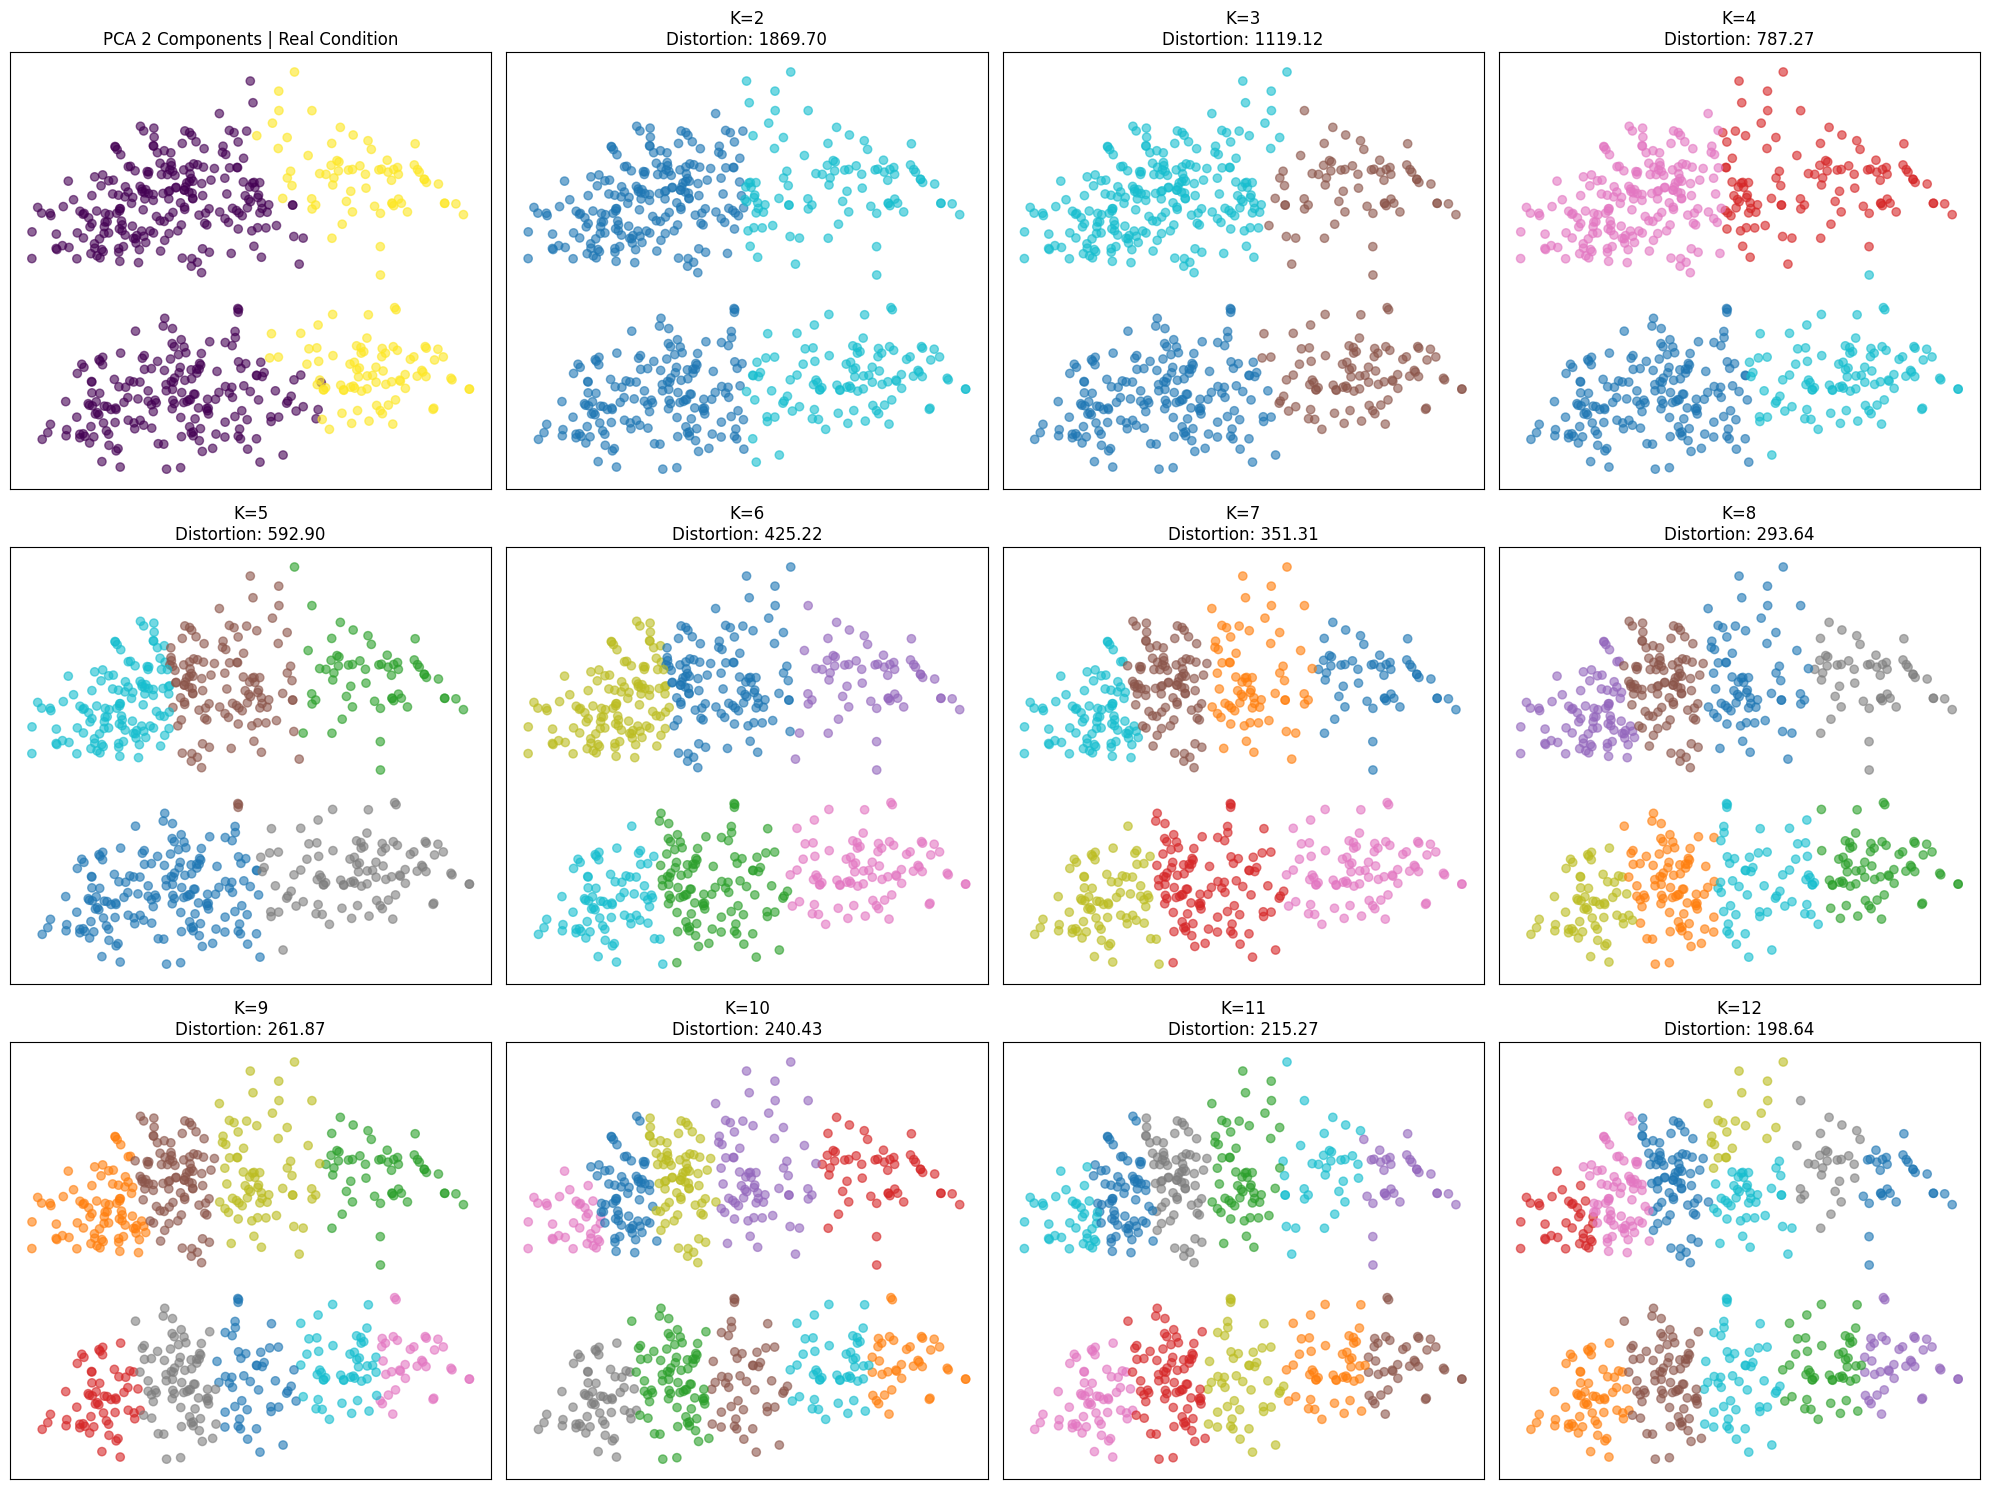

In [25]:
total_plots = len(k_values) + 1
cols = 4
rows = (total_plots // cols) + (1 if total_plots % cols != 0 else 0)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axes = axes.flatten()

axes[0].scatter(X_train_pca2[:, 0], X_train_pca2[:, 1], c=y_geometric_train, cmap='viridis', alpha=0.6)
axes[0].set_title(f"PCA 2 Components | Real Condition")
axes[0].set_xticks([])
axes[0].set_yticks([])

for i, k in enumerate(k_values):
    ax = axes[i + 1]
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train_pca2)
    
    dist = kmeans.inertia_
    
    ax.scatter(X_train_pca2[:, 0], X_train_pca2[:, 1], c=cluster_labels, cmap='tab10', alpha=0.6)
    ax.set_title(f"K={k}\nDistortion: {dist:.2f}")
    ax.set_xticks([])
    ax.set_yticks([])

for j in range(i + 2, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Testing K=2 --> Distortion: 1869.70 | Drop: 49.04%
Testing K=3 --> Distortion: 1119.12 | Drop: 40.14%
Testing K=4 --> Distortion: 787.27 | Drop: 29.65%
Testing K=5 --> Distortion: 592.90 | Drop: 24.69%
Testing K=6 --> Distortion: 425.22 | Drop: 28.28%
Testing K=7 --> Distortion: 351.31 | Drop: 17.38%
Testing K=8 --> Distortion: 293.64 | Drop: 16.41%
Testing K=9 --> Distortion: 261.87 | Drop: 10.82%
Testing K=10 --> Distortion: 240.43 | Drop: 8.19%
Testing K=11 --> Distortion: 215.27 | Drop: 10.46%
Testing K=12 --> Distortion: 198.64 | Drop: 7.73%
Testing K=13 --> Distortion: 186.12 | Drop: 6.30%
Testing K=14 --> Distortion: 173.54 | Drop: 6.76%
Testing K=15 --> Distortion: 161.19 | Drop: 7.12%
Testing K=16 --> Distortion: 151.22 | Drop: 6.19%
Testing K=17 --> Distortion: 142.54 | Drop: 5.74%
Testing K=18 --> Distortion: 134.65 | Drop: 5.54%
Testing K=19 --> Distortion: 126.84 | Drop: 5.79%
Testing K=20 --> Distortion: 121.11 | Drop: 4.52%


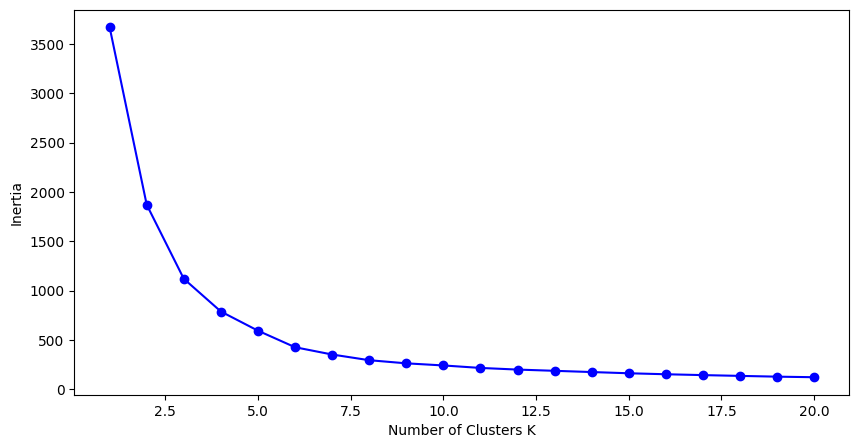

In [26]:
distortions = []
last_dist = None
k_values = list(range(1,21))


for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_pca2)
    
    current_dist = kmeans.inertia_
    distortions.append(current_dist)
    
    if last_dist is not None:
        reduction = ((last_dist - current_dist) / last_dist) * 100
        print(f"Testing K={k} --> Distortion: {current_dist:.2f} | Drop: {reduction:.2f}%")
    
    last_dist = current_dist

plt.figure(figsize=(10, 5))
plt.plot(k_values, distortions, 'bo-')
#plt.title("Elbow Method Analysis")
plt.xlabel("Number of Clusters K")
plt.ylabel("Inertia")
plt.show()

In [27]:
top_k_values = [2, 6, 11, 20]

for k in top_k_values:
    run_name = f"KMeans_K{k}_PCA2"
    
    with mlflow.start_run(run_name=run_name):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_train_pca2)
        
        test_clusters = kmeans.predict(X_test_pca2)
        
        y_test_pred = np.zeros_like(test_clusters)
        for cluster_id in range(k):
            mask = (test_clusters == cluster_id)
            if np.any(mask):
                voto = mode(y_geometric_test[mask], keepdims=True)[0][0]
                y_test_pred[mask] = voto

        mlflow.log_params({
            "n_clusters": k,
            "use_pca": True,
            "n_components": 2,
        })
        
        metrics = compute_metrics(y_geometric_test, y_test_pred)
        mlflow.log_metrics(metrics)
        plot_confusion_matrix(y_geometric_test, y_test_pred, f"K{k}_PCA2")
        
        mlflow.sklearn.log_model(sk_model=kmeans, artifact_path="model")

2026/01/06 15:05:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 15:05:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 15:05:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/01/06 15:05:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


### <span id="sec52"></span> **5.2 PCA with 3 principal components and clustering**

In [28]:
n_components_3 = 3
pca3 = PCA(n_components=n_components_3)

X_train_pca3 = pca3.fit_transform(X_geometric_train_scaled)
X_test_pca3 = pca3.transform(X_geometric_test_scaled)

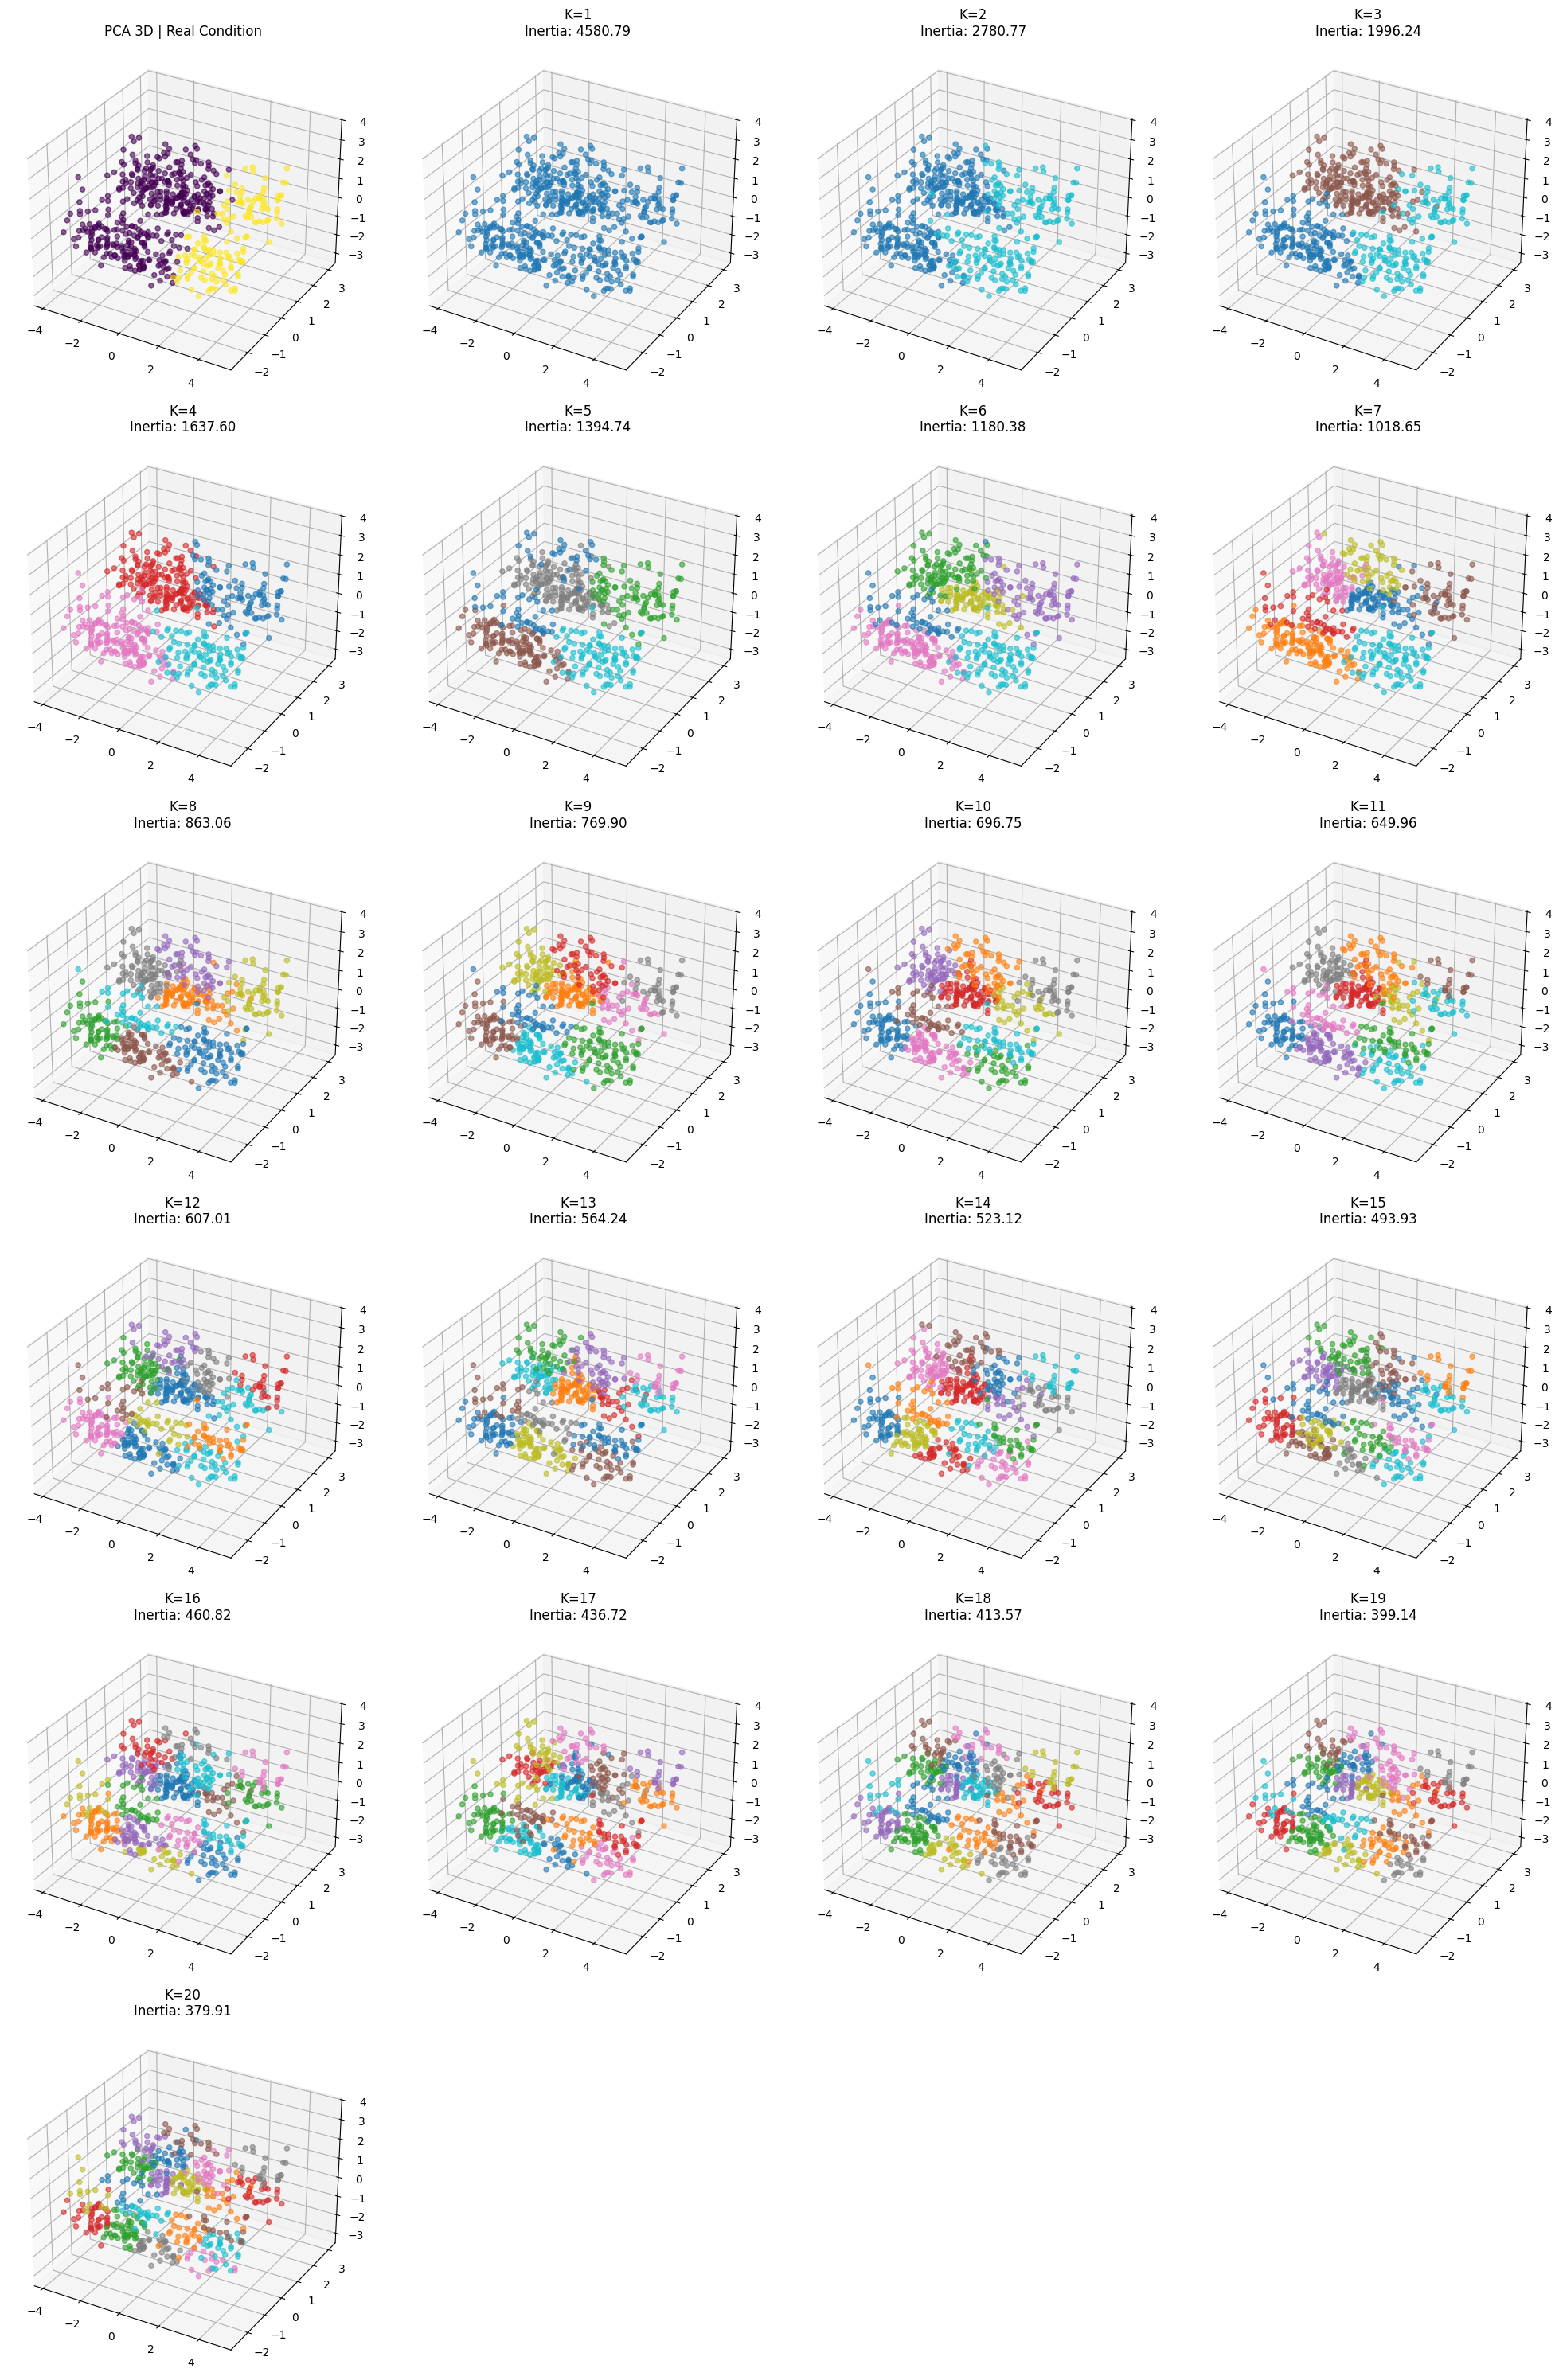

In [29]:
total_plots = len(k_values) + 1
cols = 4
rows = (total_plots // cols) + (1 if total_plots % cols != 0 else 0)

fig = plt.figure(figsize=(5 * cols, 5 * rows))

ax0 = fig.add_subplot(rows, cols, 1, projection='3d')
ax0.scatter(X_train_pca3[:, 0], X_train_pca3[:, 1], X_train_pca3[:, 2], c=y_geometric_train, cmap='viridis', alpha=0.6)
ax0.set_title("PCA 3D | Real Condition")

for i, k in enumerate(k_values):
    ax = fig.add_subplot(rows, cols, i + 2, projection='3d')
    kmeans_3d = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_3d = kmeans_3d.fit_predict(X_train_pca3)
    
    ax.scatter(X_train_pca3[:, 0], X_train_pca3[:, 1], X_train_pca3[:, 2], c=labels_3d, cmap='tab10', alpha=0.6)
    ax.set_title(f"K={k}\nInertia: {kmeans_3d.inertia_:.2f}")

plt.tight_layout()
plt.show()

In [30]:
distortions_3d = []
last_dist_3d = None

for k in range(1, 21):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_train_pca3)
    curr_dist = km.inertia_
    distortions_3d.append(curr_dist)
    
    if last_dist_3d is not None:
        drop = ((last_dist_3d - curr_dist) / last_dist_3d) * 100
        print(f"K={k} --> Distortion: {curr_dist:.2f} | Drop: {drop:.2f}%")
    last_dist_3d = curr_dist

K=2 --> Distortion: 2780.77 | Drop: 39.29%
K=3 --> Distortion: 1996.24 | Drop: 28.21%
K=4 --> Distortion: 1637.60 | Drop: 17.97%
K=5 --> Distortion: 1394.74 | Drop: 14.83%
K=6 --> Distortion: 1180.38 | Drop: 15.37%
K=7 --> Distortion: 1018.65 | Drop: 13.70%
K=8 --> Distortion: 863.06 | Drop: 15.27%
K=9 --> Distortion: 769.90 | Drop: 10.80%
K=10 --> Distortion: 696.75 | Drop: 9.50%
K=11 --> Distortion: 649.96 | Drop: 6.72%
K=12 --> Distortion: 607.01 | Drop: 6.61%
K=13 --> Distortion: 564.24 | Drop: 7.05%
K=14 --> Distortion: 523.12 | Drop: 7.29%
K=15 --> Distortion: 493.93 | Drop: 5.58%
K=16 --> Distortion: 460.82 | Drop: 6.70%
K=17 --> Distortion: 436.72 | Drop: 5.23%
K=18 --> Distortion: 413.57 | Drop: 5.30%
K=19 --> Distortion: 399.14 | Drop: 3.49%
K=20 --> Distortion: 379.91 | Drop: 4.82%


In [31]:

top_k_values = [2, 8, 14, 20]

for k in top_k_values:
    run_name = f"KMeans_K{k}_PCA3"
    
    with mlflow.start_run(run_name=run_name):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_train_pca3)
        
        test_clusters = kmeans.predict(X_test_pca3)
        
        y_test_pred = np.zeros_like(test_clusters)
        for cluster_id in range(k):
            mask = (test_clusters == cluster_id)
            if np.any(mask):
                voto = mode(y_geometric_test[mask], keepdims=True)[0][0]
                y_test_pred[mask] = voto

        mlflow.log_params({
            "n_clusters": k,
            "n_components": 3,
            "use_pca": True
        })
        
        metrics = compute_metrics(y_geometric_test, y_test_pred)
        mlflow.log_metrics(metrics)
        plot_confusion_matrix(y_geometric_test, y_test_pred, f"K{k}_PCA3_Test")
        
        mlflow.sklearn.log_model(
            sk_model=kmeans, 
            artifact_path="model",
            registered_model_name=f"KMeans_K{k}_PCA3"
        )

2026/01/06 15:05:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'KMeans_K2_PCA3'.
Created version '1' of model 'KMeans_K2_PCA3'.
2026/01/06 15:05:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'KMeans_K8_PCA3'.
Created version '1' of model 'KMeans_K8_PCA3'.
2026/01/06 15:05:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'KMeans_K14_PCA3'.
Created version '1' of model 'KMeans_K14_PCA3'.
2026/01/06 15:06:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'KMeans_K20_PCA3'.
Created version '1' of model 'KMeans_K20_PCA3'.


### <span id="sec51"></span> **5.3 PCA with 17 principal components and clustering**

In [32]:
n_components_17 = 17
pca17 = PCA(n_components=n_components_17)

X_train_pca17 = pca17.fit_transform(X_geometric_train_scaled)
X_test_pca17 = pca17.transform(X_geometric_test_scaled)

In [33]:
distortions_17c = []
last_dist_17c = None

for k in range(1, 21):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_train_pca17)
    curr_dist = km.inertia_
    distortions_17c.append(curr_dist)
    
    if last_dist_17c is not None:
        drop = ((last_dist_17c - curr_dist) / last_dist_17c) * 100
        print(f"K={k} --> Distortion: {curr_dist:.2f} | Drop: {drop:.2f}%")
    last_dist_17c = curr_dist

K=2 --> Distortion: 11278.24 | Drop: 13.85%
K=3 --> Distortion: 10480.00 | Drop: 7.08%
K=4 --> Distortion: 9938.75 | Drop: 5.16%
K=5 --> Distortion: 9434.31 | Drop: 5.08%
K=6 --> Distortion: 8974.54 | Drop: 4.87%
K=7 --> Distortion: 8472.55 | Drop: 5.59%
K=8 --> Distortion: 7929.91 | Drop: 6.40%
K=9 --> Distortion: 7413.65 | Drop: 6.51%
K=10 --> Distortion: 6863.70 | Drop: 7.42%
K=11 --> Distortion: 6569.35 | Drop: 4.29%
K=12 --> Distortion: 6100.30 | Drop: 7.14%
K=13 --> Distortion: 5550.94 | Drop: 9.01%
K=14 --> Distortion: 5039.04 | Drop: 9.22%
K=15 --> Distortion: 4803.25 | Drop: 4.68%
K=16 --> Distortion: 4638.92 | Drop: 3.42%
K=17 --> Distortion: 4344.52 | Drop: 6.35%
K=18 --> Distortion: 4233.28 | Drop: 2.56%
K=19 --> Distortion: 4106.04 | Drop: 3.01%
K=20 --> Distortion: 3959.44 | Drop: 3.57%


In [34]:
top_k_values = [2, 7, 12, 20]

for k in top_k_values:
    run_name = f"KMeans_K{k}_PCA17"
    
    with mlflow.start_run(run_name=run_name):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_train_pca17)
        
        test_clusters = kmeans.predict(X_test_pca17)
        
        y_test_pred = np.zeros_like(test_clusters)
        for cluster_id in range(k):
            mask = (test_clusters == cluster_id)
            if np.any(mask):
                voto = mode(y_geometric_test[mask], keepdims=True)[0][0]
                y_test_pred[mask] = voto

        mlflow.log_params({
            "n_clusters": k,
            "pca_components": n_components_17,
            "use_pca": True
        })
        
        metrics = compute_metrics(y_geometric_test, y_test_pred)
        mlflow.log_metrics(metrics)
        plot_confusion_matrix(y_geometric_test, y_test_pred, f"K{k}_PCA17_Test")
        
        mlflow.sklearn.log_model(
            sk_model=kmeans, 
            artifact_path="model",
            registered_model_name=f"KMeans_K{k}_PCA17"
        )

2026/01/06 15:06:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'KMeans_K2_PCA17'.
Created version '1' of model 'KMeans_K2_PCA17'.
2026/01/06 15:06:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'KMeans_K7_PCA17'.
Created version '1' of model 'KMeans_K7_PCA17'.
2026/01/06 15:06:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'KMeans_K12_PCA17'.
Created version '1' of model 'KMeans_K12_PCA17'.
2026/01/06 15:06:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'KMeans_K20_PCA17'.
Created version '1' of model 'KMeans_K20_PCA17'.


### <span id="sec54"></span> **5.4 Without PCA and clustering**

In [35]:
distortions_geo = []
last_dist_geo = None

for k in range(1, 21):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_geometric_train_scaled)
    curr_dist = km.inertia_
    distortions_geo.append(curr_dist)
    
    if last_dist_geo is not None:
        drop = ((last_dist_geo - curr_dist) / last_dist_geo) * 100
        print(f"K={k} --> Distortion: {curr_dist:.2f} | Drop: {drop:.2f}%")
    last_dist_geo = curr_dist

K=2 --> Distortion: 14511.60 | Drop: 11.12%
K=3 --> Distortion: 13701.16 | Drop: 5.58%
K=4 --> Distortion: 13317.63 | Drop: 2.80%
K=5 --> Distortion: 12718.86 | Drop: 4.50%
K=6 --> Distortion: 12043.70 | Drop: 5.31%
K=7 --> Distortion: 11584.87 | Drop: 3.81%
K=8 --> Distortion: 11093.40 | Drop: 4.24%
K=9 --> Distortion: 10503.22 | Drop: 5.32%
K=10 --> Distortion: 9871.68 | Drop: 6.01%
K=11 --> Distortion: 9599.70 | Drop: 2.76%
K=12 --> Distortion: 9036.64 | Drop: 5.87%
K=13 --> Distortion: 8497.61 | Drop: 5.96%
K=14 --> Distortion: 8118.54 | Drop: 4.46%
K=15 --> Distortion: 7747.21 | Drop: 4.57%
K=16 --> Distortion: 7745.00 | Drop: 0.03%
K=17 --> Distortion: 7468.77 | Drop: 3.57%
K=18 --> Distortion: 7037.81 | Drop: 5.77%
K=19 --> Distortion: 6881.27 | Drop: 2.22%
K=20 --> Distortion: 6918.14 | Drop: -0.54%


In [36]:
top_k_values = [2, 10, 15, 20]

for k in top_k_values:
    run_name = f"KMeans_K{k}_NoPCA"
    
    with mlflow.start_run(run_name=run_name):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_geometric_train_scaled)
        
        test_clusters = kmeans.predict(X_geometric_test_scaled)
        
        y_test_pred = np.zeros_like(test_clusters)
        for cluster_id in range(k):
            mask = (test_clusters == cluster_id)
            if np.any(mask):
                voto = mode(y_geometric_test[mask], keepdims=True)[0][0]
                y_test_pred[mask] = voto

        mlflow.log_params({
            "n_clusters": k,
            "n_components": X_geometric_train_scaled.shape[1], 
            "use_pca": False,
        })
        
        metrics = compute_metrics(y_geometric_test, y_test_pred)
        mlflow.log_metrics(metrics)
        plot_confusion_matrix(y_geometric_test, y_test_pred, f"K{k}_NoPCA_Test")
        
        mlflow.sklearn.log_model(
            sk_model=kmeans, 
            artifact_path="model",
            registered_model_name=f"KMeans_K{k}_NoPCA"
        )
        

2026/01/06 15:06:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'KMeans_K2_NoPCA'.
Created version '1' of model 'KMeans_K2_NoPCA'.
2026/01/06 15:06:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'KMeans_K10_NoPCA'.
Created version '1' of model 'KMeans_K10_NoPCA'.
2026/01/06 15:06:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'KMeans_K15_NoPCA'.
Created version '1' of model 'KMeans_K15_NoPCA'.
2026/01/06 15:06:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'KMeans_K20_NoPCA'.
Created version '1' of model 'KMeans_K20_NoPCA'.


## <span id="sec6"></span> **6. Modeling phase BNN**

In [37]:
df_train_bayesian, df_test_bayesian = train_test_split(
    df_bayesian, test_size=0.2, random_state=42, stratify=df_bayesian['ASD_TARGET']
)

def graficar_grafo_bayeseano(modelo_grafo, target_name, filename):
    G = nx.DiGraph()
    G.add_edges_from(modelo_grafo.edges())
    
    plt.figure(figsize=(25, 15))
    pos = nx.spring_layout(G, k=5.0, iterations=200, seed=42)
    
    nodos_target = [n for n in G.nodes() if n == target_name]
    nodos_otros = [n for n in G.nodes() if n != target_name]
    
    nx.draw_networkx_nodes(G, pos, nodelist=nodos_otros, node_color='#A0CBE2', 
                           node_size=4500, alpha=0.8, edgecolors='#333333', linewidths=1.2)
    nx.draw_networkx_nodes(G, pos, nodelist=nodos_target, node_color='#FF8C00', 
                           node_size=6500, alpha=1.0, edgecolors='#CC5500', linewidths=3)
    
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_family='sans-serif')
    
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='#444444', 
                           width=2.2, arrows=True, arrowsize=35, 
                           connectionstyle='arc3,rad=0.2', 
                           min_source_margin=25, min_target_margin=25)
    
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename, format="png", dpi=300, bbox_inches='tight')
    plt.show()

target_col = 'ASD_TARGET'
columnas_predictoras = [col for col in df_bayesian.columns if col != target_col]
mi_black_list = [(target_col, col) for col in columnas_predictoras]

In [38]:
mlflow.set_experiment("BN_Models")

2026/01/06 15:06:27 INFO mlflow.tracking.fluent: Experiment with name 'BN_Models' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:///home/paul/univerirsidad/septimo/IA/Practicas/Practica '
 'Cuatro/Practica 4/notebooks/../mlruns/905126046497986958'), creation_time=1767729987590, experiment_id='905126046497986958', last_update_time=1767729987590, lifecycle_stage='active', name='BN_Models', tags={}>

100%|██████████| 139/139 [00:00<00:00, 423.68it/s]


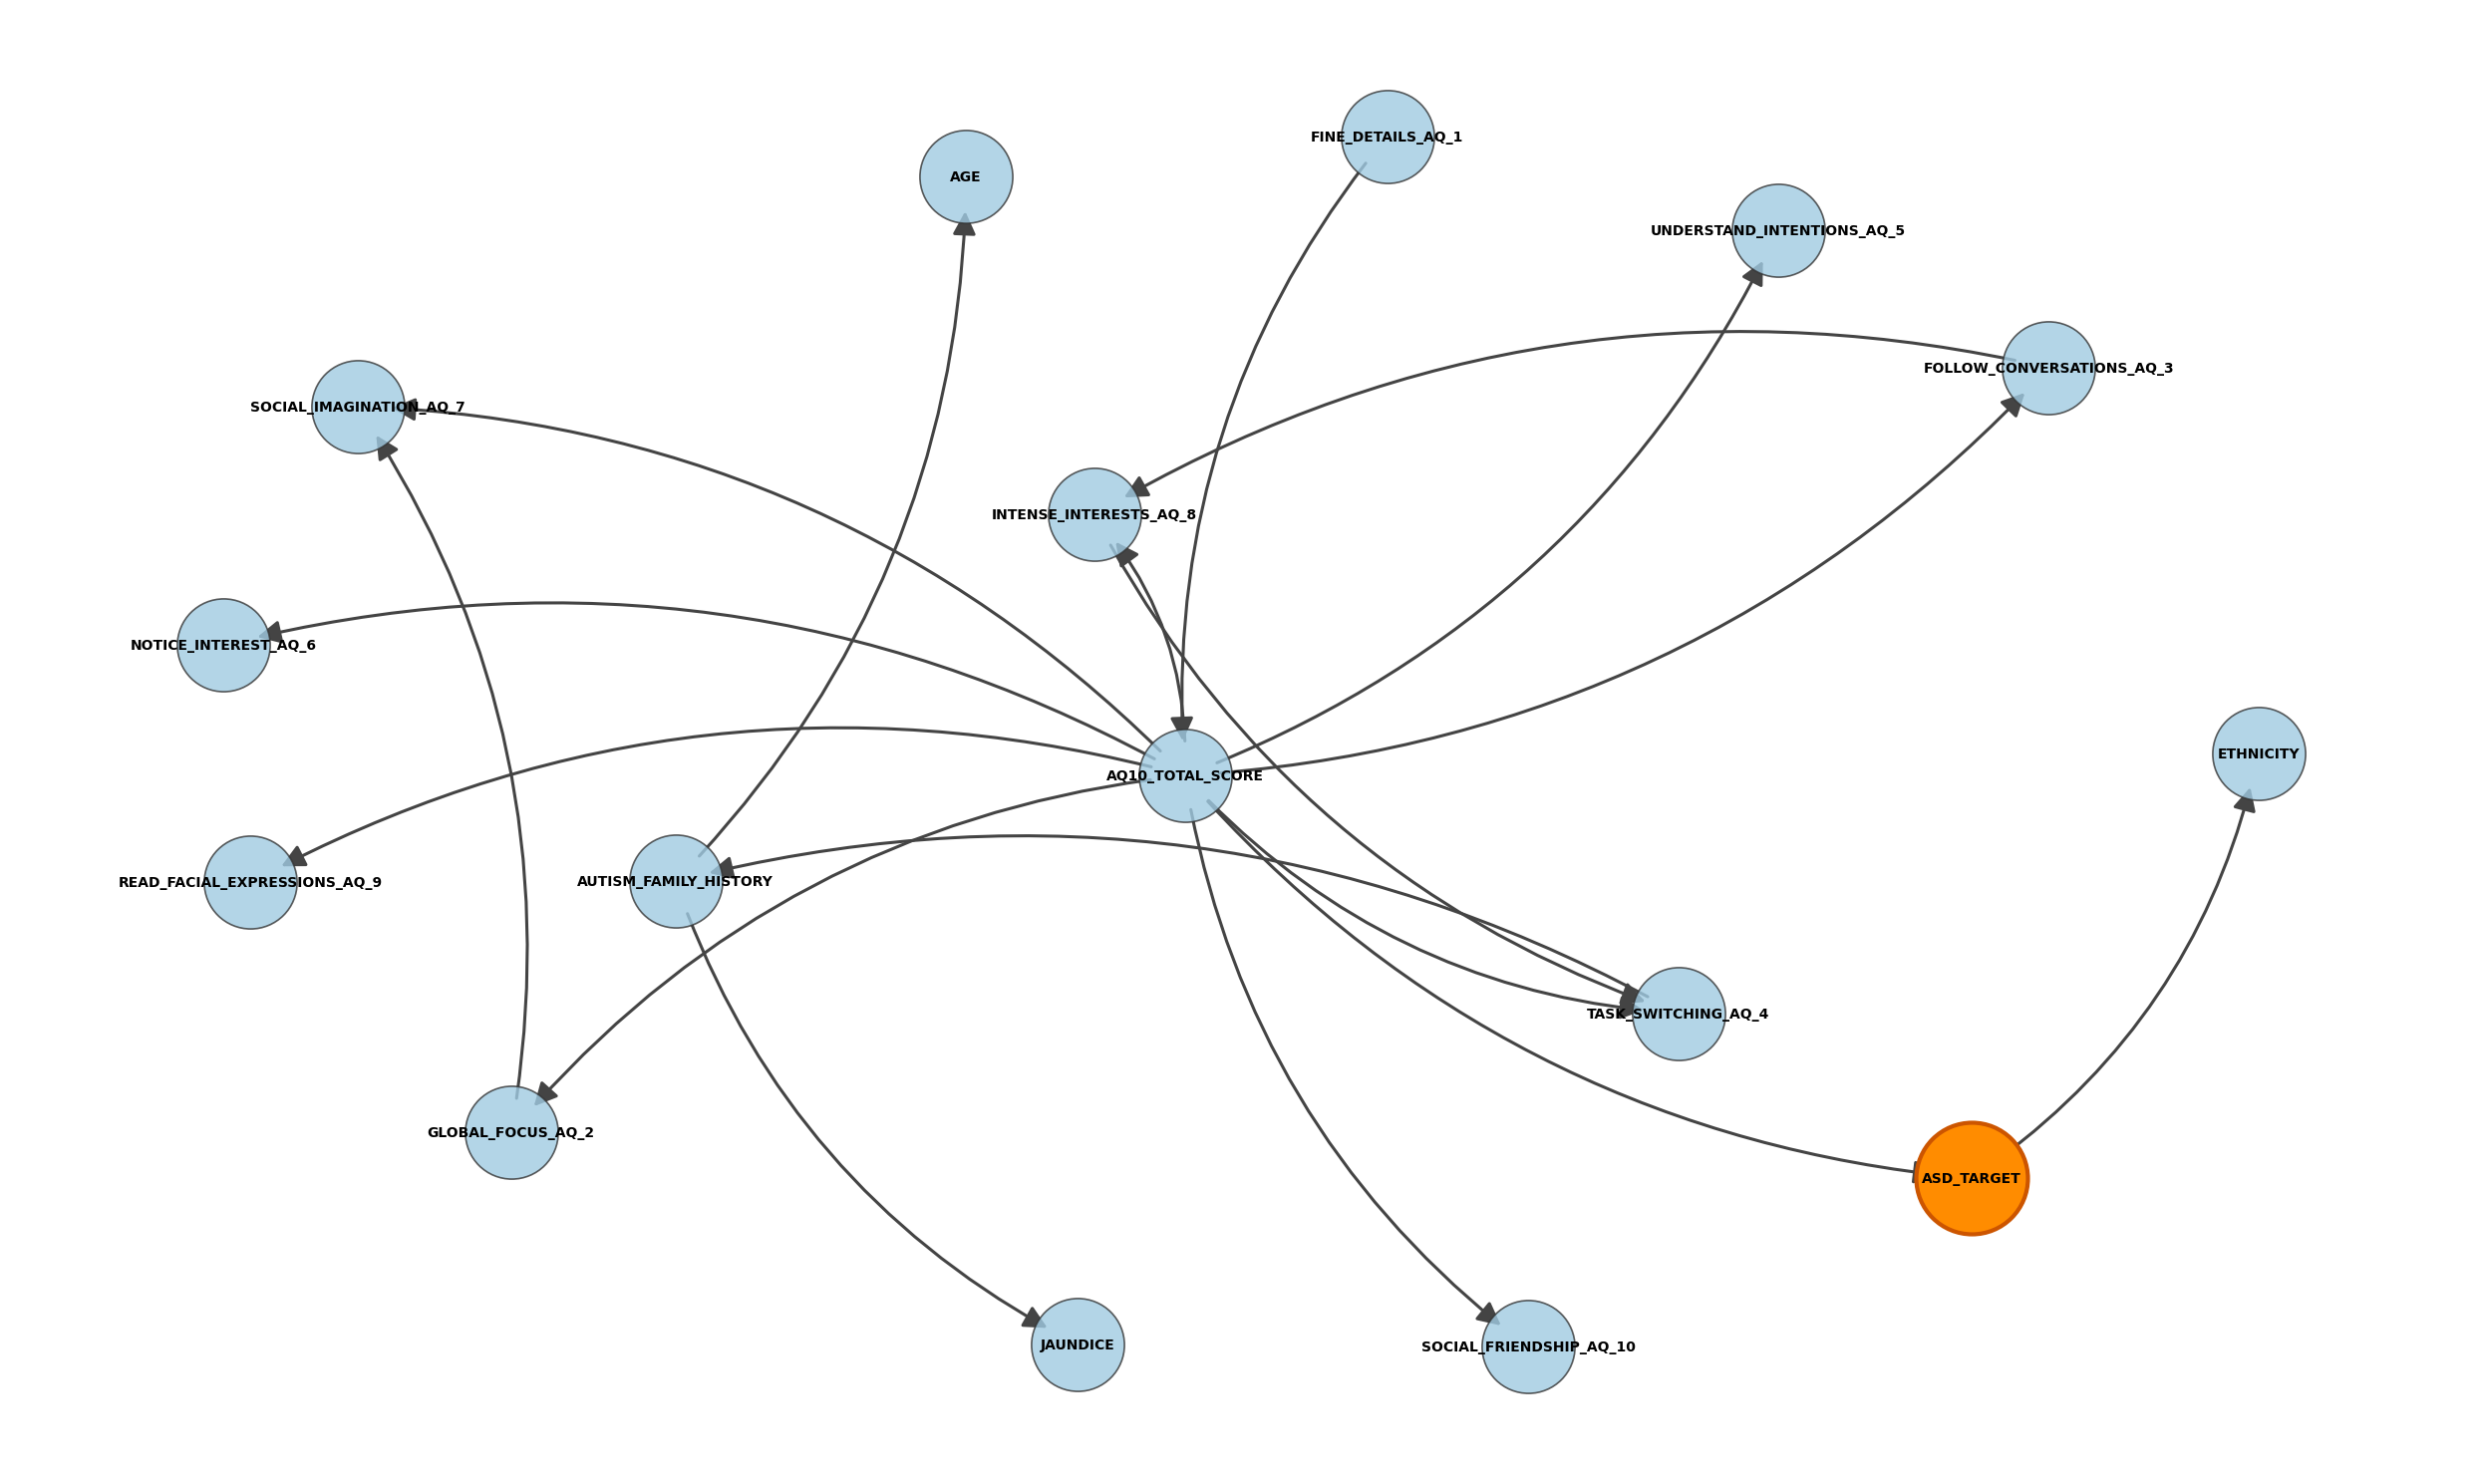

2026/01/06 15:06:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


In [39]:
with mlflow.start_run(run_name="BNLearn_Structure_Discovery"):
    
    model_structure = bn.structure_learning.fit(
        df_train_bayesian, 
        methodtype='hc', 
        scoretype='bic',
        black_list=mi_black_list,
        bw_list_method='hc',
        verbose=0
    )
    
    model_final = bn.parameter_learning.fit(model_structure, df_train_bayesian, verbose=0)
    
    nodos_en_grafo = list(model_final['model'].nodes())
    nodos_evidencia = [n for n in nodos_en_grafo if n != target_col]
    X_test_bayesian = df_test_bayesian[nodos_evidencia]
    
    y_pred_df = bn.predict(model_final, X_test_bayesian, variables=[target_col], verbose=0)
    y_pred_bayesian = y_pred_df[target_col].values
    
    metrics_bayesian = compute_metrics(df_test_bayesian[target_col], y_pred_bayesian)
    mlflow.log_metrics(metrics_bayesian)
    
    plot_confusion_matrix(df_test_bayesian[target_col], y_pred_bayesian, "BN_Discovery")
    
    graph_file = "../_attachments/img/graph_bnn.png"
    graficar_grafo_bayeseano(model_structure['model'], target_col, graph_file)
    mlflow.log_artifact(graph_file)
    
    mlflow.log_params({
        "n_nodes": len(nodos_en_grafo),
        "method": "hc_bic",
        "discarded_nodes": list(set(df_bayesian.columns) - set(nodos_en_grafo))
    })
    
    mlflow.sklearn.log_model(sk_model=model_final['model'], artifact_path="model_bayesian")


## <span id="sec7"></span> **7. Comparation**

In [40]:
experiment_names = ['KNN_Models', 'BN_Models', 'ANN_Models', 'Cluster_Models']
results_list = []

best_knn_model = None
best_bn_model = None
best_ann_model = None
best_cluster_model = None

for name in experiment_names:
    exp = mlflow.get_experiment_by_name(name)
    
    if exp is not None:
        runs_df = mlflow.search_runs(
            experiment_ids=[exp.experiment_id],
            max_results=1,
            order_by=["metrics.accuracy DESC"]
        )
        
        if not runs_df.empty:
            best_run = runs_df.iloc[0]
            run_id = best_run['run_id']
            
            results_list.append({
                "Experiment": name,
                "Run_ID": run_id,
                "Accuracy": best_run.get("metrics.accuracy", 0),
                "Precision": best_run.get("metrics.precision", 0),
                "Recall": best_run.get("metrics.recall", 0),
                "F1": best_run.get("metrics.f1_score", 0)
            })


            folder_name = "model_bayesian" if name == 'BN_Models' else "model"
            model_uri = f"runs:/{run_id}/{folder_name}"
            
            try:
                if name == 'KNN_Models':
                    best_knn_model = mlflow.sklearn.load_model(model_uri)
                elif name == 'BN_Models':
    
                    best_bn_model = mlflow.sklearn.load_model(model_uri)
                elif name == 'ANN_Models':
                    best_ann_model = mlflow.sklearn.load_model(model_uri)
                elif name == 'Cluster_Models':
                    best_cluster_model = mlflow.sklearn.load_model(model_uri)
            except Exception as e:
                print(f"Warning: Could not load model for {name} using path '{folder_name}'. Error: {e}")

In [41]:
# 1. TABLE
df_results = pd.DataFrame(results_list)
display(df_results)

Experiment                            Run_ID  Accuracy  Precision  \
0      KNN_Models  084ad08e78814813af0d82d81c39807c  0.879433   1.000000   
1       BN_Models  e3c75fb43039454abcadf6456f6e3f39  1.000000   1.000000   
2      ANN_Models  cf028a31b90642ceafdfd92c033a1474  0.900709   1.000000   
3  Cluster_Models  f64b60ec96fb46ce9fda639e4dde830a  0.943262   0.857143   

     Recall        F1  
0  0.552632  0.711864  
1  1.000000  1.000000  
2  0.631579  0.774194  
3  0.947368  0.900000

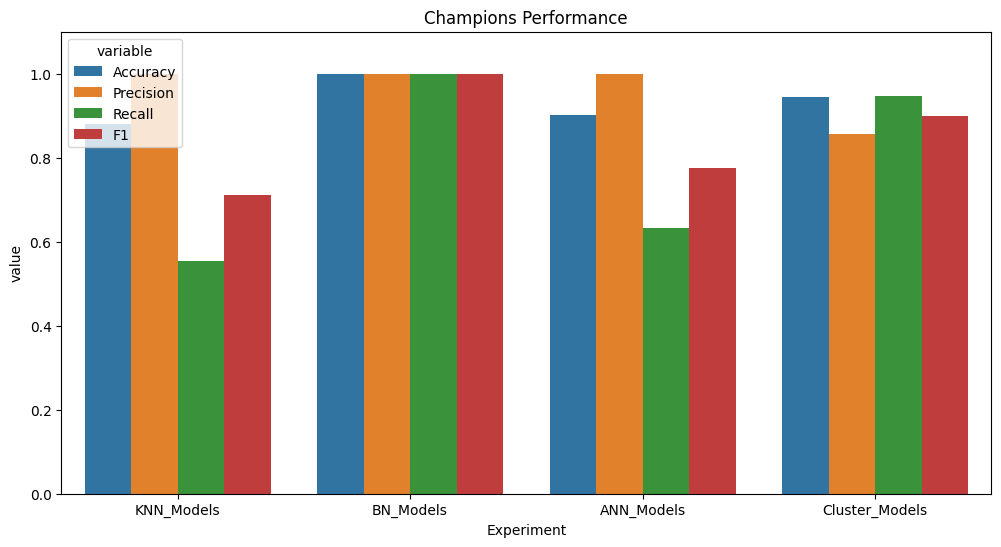

In [42]:
df_melted = df_results.melt(id_vars="Experiment", value_vars=["Accuracy", "Precision", "Recall", "F1"])
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Experiment", y="value", hue="variable")
plt.ylim(0, 1.1)
plt.title("Champions Performance")
plt.show()

## <span id="sec8"></span> **8. Prediction**

## <span id="sec9"></span> **9. Conclusion**